# Calculate and Plot Phasors on Synthetic Data

In this notebook, we make some synthetic data by creating exponential curves with different decays and pulsed laser frequencies. We then build the phasor plots for these "single-pixel images" and compare their position in the plot against the theoretical position.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
# from FLIM_phasor import *
from napari_flim_phasor_plotter._synthetic import create_time_array, make_synthetic_flim_data, monoexp
from napari_flim_phasor_plotter.phasor import get_phasor_components
from napari_flim_phasor_plotter._plotting import add_phasor_circle, add_tau_lines
import dask.array as da

New version based on [hsitools](https://github.com/schutyb/rep-hsipy/blob/main/scripts/hsitools.py). Make a PR there.

In [2]:
import numba as nb
import numpy as np

def phasor(image_stack, harmonic=1):
    """
	This function computes the average intensity image, the G and S coordinates, modulation and phase.

	:param image_stack: is a file with spectral mxm images to calculate the fast fourier transform from numpy library.
	:param harmonic: int. The number of the harmonic where the phasor is calculated.
	harmonic range: [1, num of channels - 1]
	:return: avg: is the average intensity image
	:return: g: is mxm image with the real part of the fft.
	:return: s: is mxm imaginary with the real part of the fft.
	:return: md: is the modulus obtain with Euclidean Distance.
	:return: ph: is the phase between g and s in degrees.
	"""

    import dask.array as da
    if image_stack.any():
        if isinstance(harmonic, int) and 0 < harmonic < image_stack.shape[0]:

            if isinstance(image_stack, da.Array):
                fft_slice_function = fft_slice_dask
            else:
                fft_slice_function = fft_slice
            
            dc, harmonic_slice = fft_slice_function(image_stack, slice_num=harmonic, axis=0, norm='ortho')
            dc = np.where(dc != 0, dc, int(np.mean(dc)))
            g, s = harmonic_slice.real, harmonic_slice.imag
            g /= dc
            s /= -dc
            md = np.sqrt(g ** 2 + s ** 2)
            phaux = np.angle(harmonic_slice, deg=True)
            ph = np.where(phaux < 0, phaux + 360, phaux)
            avg = np.mean(image_stack, axis=0)
            avg = avg / avg.max() * 255
        else:
            raise ValueError(
                "harmonic indices is not integer or slice or harmonic out of range\n harmonic range: [1, ""num of channels - 1]")
        return avg, g, s, md, ph
    else:
        raise ValueError("Image stack data is an empty array")


@nb.njit
def jit_fft(a, axis=0, norm=None):
    """Numba fft version with rocket-fft"""
    return np.fft.fft(a, axis=axis, norm=norm)


def fft_slice(arr, slice_num, axis=0, norm=None, *args, **kwargs):
    """
    Slice of FFT over first axis of a numpy array
    
    Parameters
    ----------
    arr : numpy array
        Array to apply FFT
    slice_num : int
        Slice number to return
    axis : int, optional
        Axis to perform FFT along, by default 0
    norm : {None, "ortho"}, optional
        Normalization to apply to FFT, by default None

    Returns
    -------
    numpy arrays
        zero-frequency part component and selected harmonic part
    """
    fft_arr = jit_fft(arr, axis=axis, norm=norm)
    # Return the specified slice of the FFT array
    return fft_arr[0, ...].real, fft_arr[slice_num, ...]


def fft_slice_dask(arr, slice_num, axis=0, *args, **kwargs):
    """
    Slice of FFT over first axis of a dask array
    
    Parameters
    ----------
    arr : dask array
        Array to apply FFT
    slice_num : int
        Slice number to return
    axis : int, optional
        Axis to perform FFT along, by default 0

    Returns
    -------
    dask arrays
        zero-frequency part component and selected harmonic part
    """
    import dask.array as da
    # Dask fft along first axis
    fft_arr = da.fft.fft(arr, axis=axis) # dask.array.fft.fft has no 'norm' argument yet
    # Return the specified slice of the FFT array
    return fft_arr[0, ...].real, fft_arr[slice_num, ...]


## Generating Synthetic FLIM data

Input options:

In [3]:
laser_frequency = 60 # MHz
amplitude = [1, 1, 2, 2]
tau = [0.8, 2, 0.8, 2] # ns
number_of_harmonics = 5
number_of_time_points = 270

### Creating time array

In [4]:
time_array = create_time_array(laser_frequency, number_of_time_points)
time_array

array([ 0.        ,  0.0617284 ,  0.12345679,  0.18518519,  0.24691358,
        0.30864198,  0.37037037,  0.43209877,  0.49382716,  0.55555556,
        0.61728395,  0.67901235,  0.74074074,  0.80246914,  0.86419753,
        0.92592593,  0.98765432,  1.04938272,  1.11111111,  1.17283951,
        1.2345679 ,  1.2962963 ,  1.35802469,  1.41975309,  1.48148148,
        1.54320988,  1.60493827,  1.66666667,  1.72839506,  1.79012346,
        1.85185185,  1.91358025,  1.97530864,  2.03703704,  2.09876543,
        2.16049383,  2.22222222,  2.28395062,  2.34567901,  2.40740741,
        2.4691358 ,  2.5308642 ,  2.59259259,  2.65432099,  2.71604938,
        2.77777778,  2.83950617,  2.90123457,  2.96296296,  3.02469136,
        3.08641975,  3.14814815,  3.20987654,  3.27160494,  3.33333333,
        3.39506173,  3.45679012,  3.51851852,  3.58024691,  3.64197531,
        3.7037037 ,  3.7654321 ,  3.82716049,  3.88888889,  3.95061728,
        4.01234568,  4.07407407,  4.13580247,  4.19753086,  4.25

### Plotting an Exponential Function
Here we plot a mono-exponential function with a given initial amplitude and decay or [time constant (tau)](https://en.wikipedia.org/wiki/Time_constant)

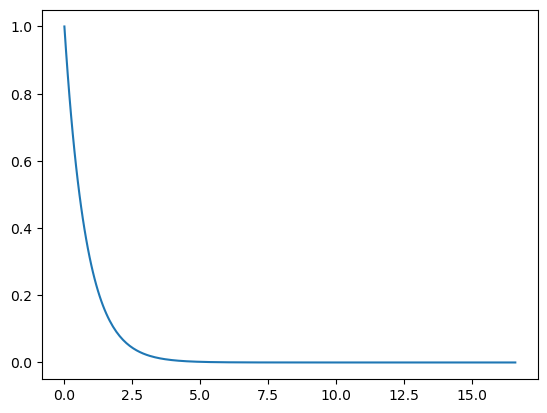

In [5]:
plt.plot(time_array, monoexp(time_array, amplitude[0], tau[0]))

### Generating a Synthetic FLIM Image
We can create a synthetic linear FLIM image where each pixel will contain an exponential curve given by a specific amplitude and a decay. The amplitudes and decays can be given as a list of values. In the example below, we use a single value, therefore, we produce a "single-pixel image".

In [6]:
flim_data = make_synthetic_flim_data(time_array, amplitude, tau).reshape(number_of_time_points, 2, 2)

In [7]:
da_flim_data = da.from_array(flim_data)
da_flim_data

dask.array<array, shape=(270, 2, 2), dtype=float64, chunksize=(270, 2, 2), chunktype=numpy.ndarray>

In [8]:
da_flim_data = da_flim_data.rechunk(chunks={1: -1})
da_flim_data

dask.array<array, shape=(270, 2, 2), dtype=float64, chunksize=(270, 2, 2), chunktype=numpy.ndarray>

## Displaying the Phasor Plot for Different Harmonics

Below we plot up to 5 harmonics for a single tau and the theoretical position as a line.

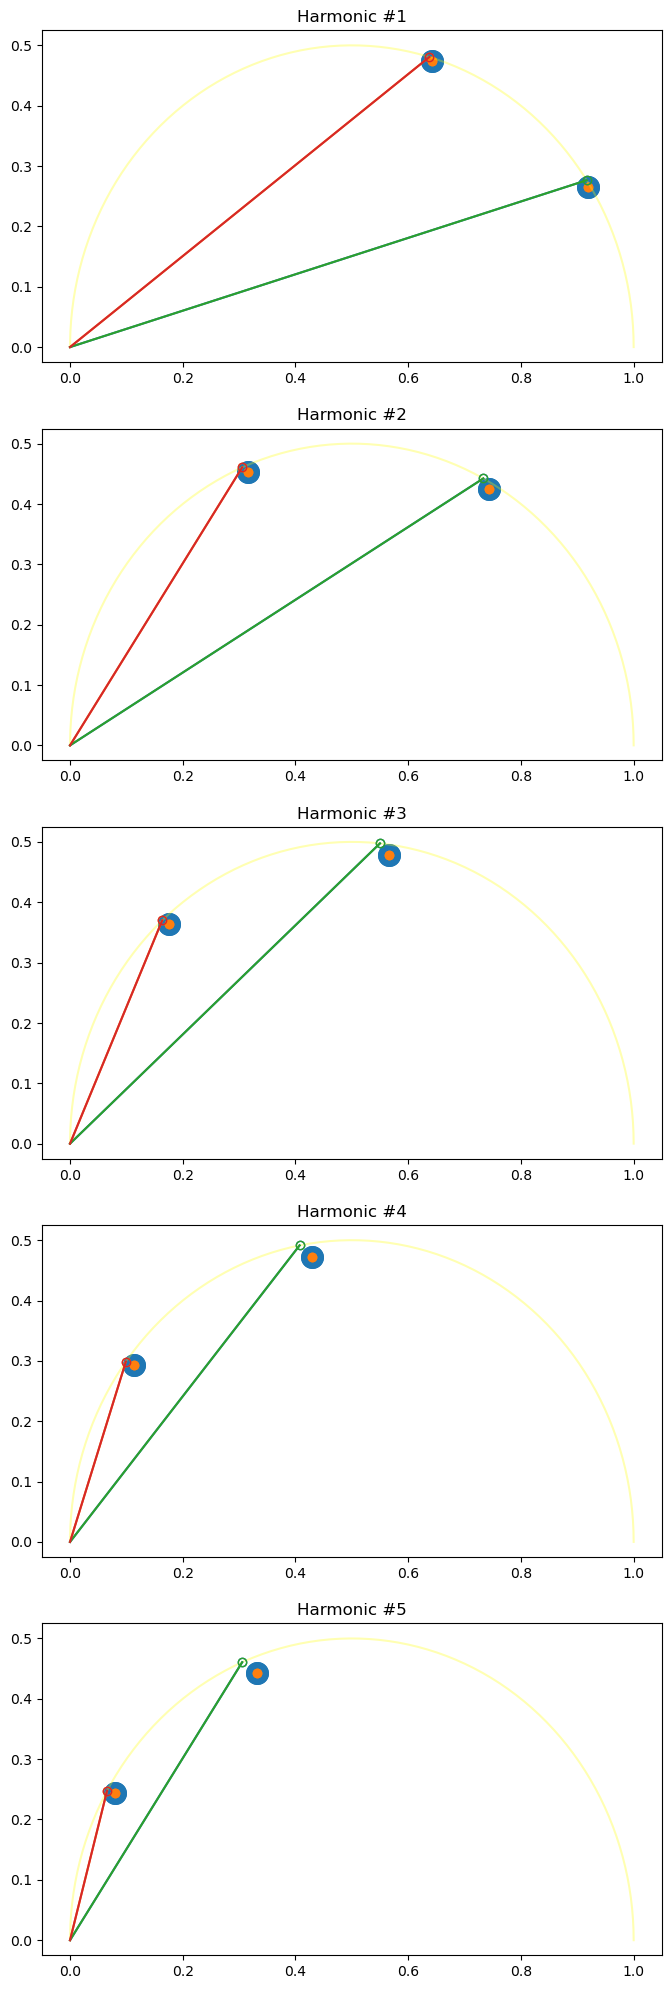

In [10]:
fig, ax = plt.subplots(number_of_harmonics, 1, figsize=(8, number_of_harmonics*5))
for i in range(number_of_harmonics):
    g, s, dc = get_phasor_components(flim_data, harmonic = i+1)
    avg, g2, s2, md, ph = phasor(flim_data, harmonic = i+1)
    x = np.ravel(g)
    y = np.ravel(s)
    x2= np.ravel(g2)
    y2 = np.ravel(s2)
    add_phasor_circle(ax[i])
    ax[i].scatter(x, y, s=240)
    ax[i].scatter(x2, y2)
    title = 'Harmonic #' + str(i+1)
    ax[i].set_title(title)
    add_tau_lines(ax[i], tau, (i+1)*laser_frequency)

There is a certain mismatch due to the sampling frequency. We can artificially increase the sampling frequency by increasing the number of time points. This way, the mismatch decreases.

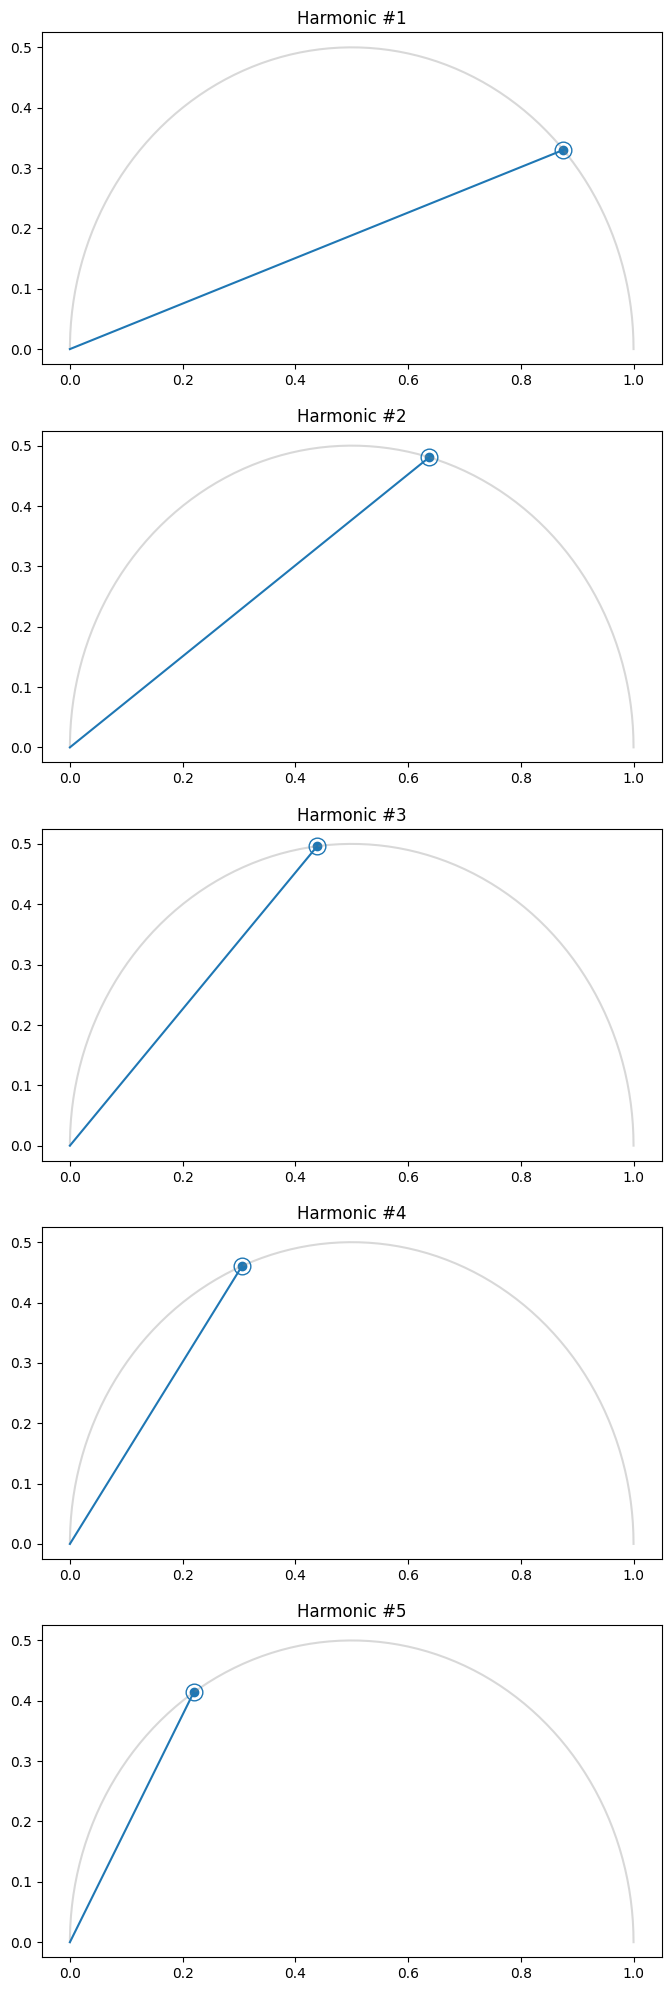

In [8]:
number_of_time_points = 27000
time_array = create_time_array(laser_frequency, number_of_time_points)

flim_data = make_synthetic_flim_data(time_array, amplitude, tau)

fig, ax = plt.subplots(number_of_harmonics, 1, figsize=(8, number_of_harmonics*5))
for i in range(number_of_harmonics):
    g, s, dc = get_phasor_components(flim_data, harmonic = i+1)
    x = np.ravel(g)
    y = np.ravel(s)
    add_phasor_circle(ax[i])
    ax[i].scatter(x, y)
    title = 'Harmonic #' + str(i+1)
    ax[i].set_title(title)
    add_tau_lines(ax[i], tau, (i+1)*laser_frequency)

## Displaying Time Plots and Phasor Plots for Different Decays and Laser Frequencies

Below we plot the first harmonics for a list of different tau and a list of different frequencies. Each tau is displayed with a different color, and each frequency is displayed in a different plot.

In [11]:
number_of_harmonics = 1
amplitude = 1
tau_list = [0.1, 0.2, 0.5, 1, 2, 5, 10, 25, 40] # ns
frequency_list = [40, 60, 80] # MHz
number_of_time_points = 270

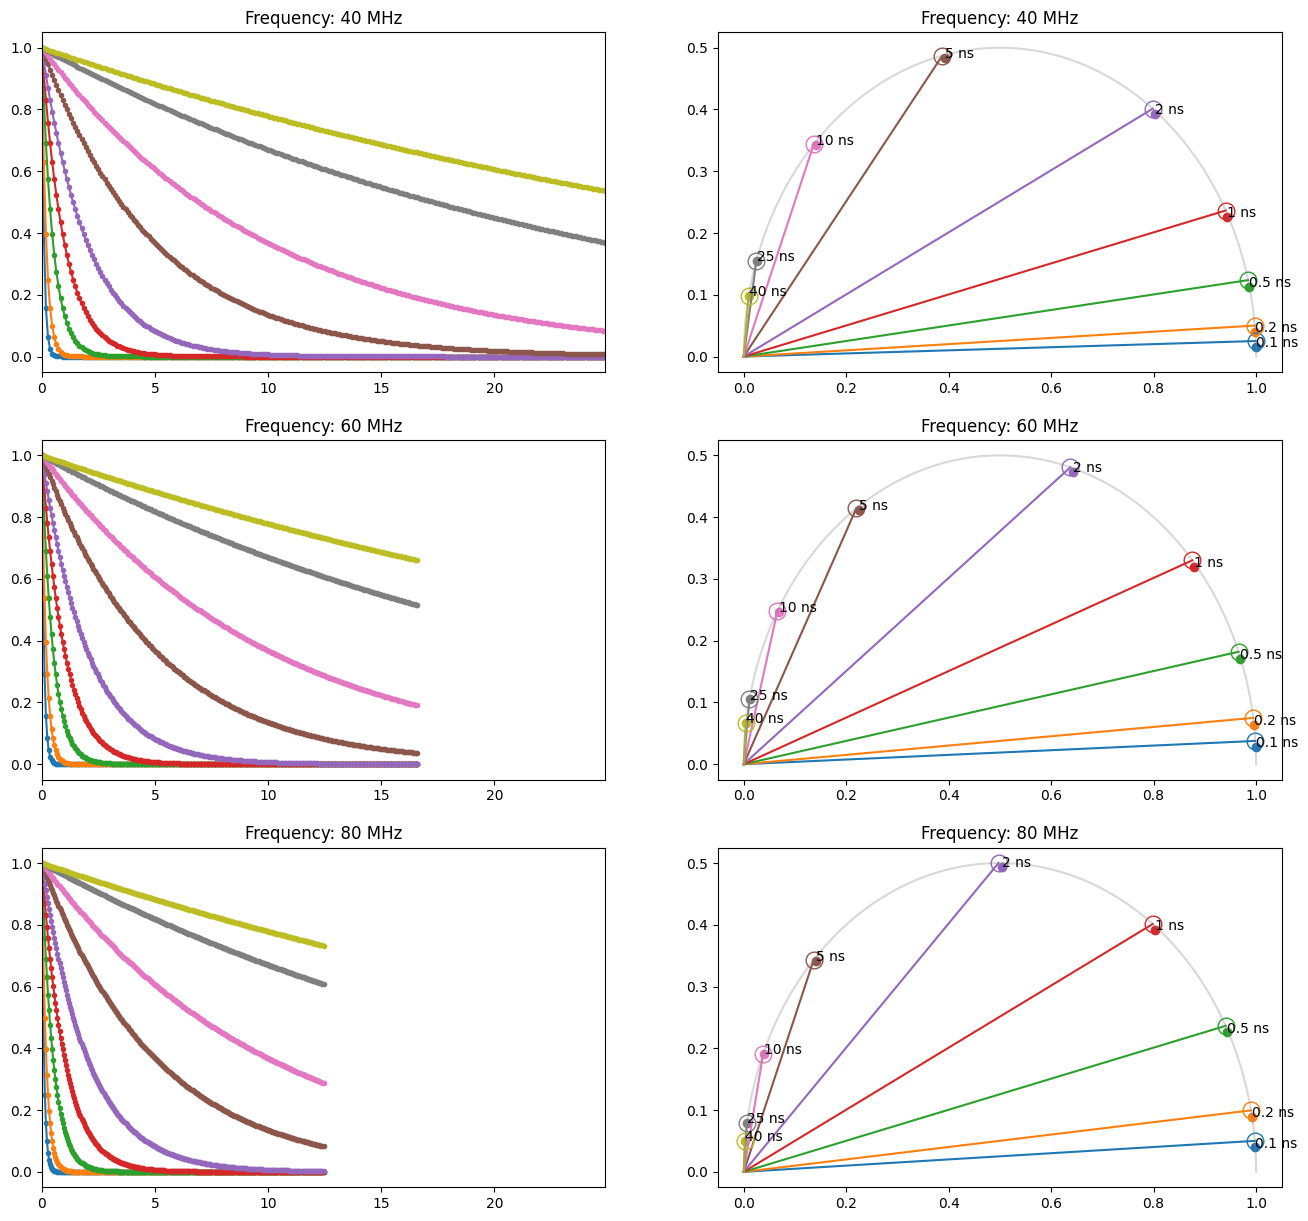

In [13]:
fig, ax = plt.subplots(len(frequency_list), 2, figsize=(16, len(frequency_list)*5))
max_time = []
for i, frequency in enumerate(frequency_list):
    time_array = create_time_array(frequency, number_of_time_points)
    max_time.append(max(time_array))
    for tau in tau_list:
        # Plot time domain
        line, = ax[i,0].plot(time_array, monoexp(time_array, amplitude, tau))
        ax[i,0].plot(time_array, monoexp(time_array, amplitude, tau), '.', color = line.get_color())
        
        # Phasor plot
        flim_data = make_synthetic_flim_data(time_array, amplitude, tau)
        g, s, dc = get_phasor_components(flim_data, harmonic = 1)
        x = np.ravel(g)
        y = np.ravel(s)
        ax[i,1].scatter(x, y)
        text = str(tau) + ' ns'
        ax[i,1].text(x, y, text)
        add_tau_lines(ax[i,1], tau, frequency)
    add_phasor_circle(ax[i,1])
    
    title = 'Frequency: ' + str(frequency) + ' MHz'
    ax[i,0].set_title(title)
    ax[i,0].set_xlim(0, max(max_time))
    ax[i,1].set_title(title)